In [1]:
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
sys.path.append("../..")
import fine_tuning.fine_tuning as fine_tuning

In [2]:
# Setup
data_path = "../../data/sentiment/"
task = "sentiment"
short_model_name = "xlm-roberta"
experiment = "tfm"
checkpoints_path = "E:/TFM_CCIL/checkpoints/"
use_class_weights = False
training_lang = "en"
learning_rate = 2e-5
epochs = 10

trainer = fine_tuning.Trainer(training_lang, data_path, task, short_model_name, use_class_weights)
trainer.setup_checkpoint(checkpoints_path)

# Experimental variables
batch_size_list = [1, 4, 8, 16, 32]
max_length_list = [512, 512, 256, 128, 64]
limit_list = [100, 500, 1000, 2000, 3000]

Checkpoint file: E:/TFM_CCIL/checkpoints/en/tf-xlm-roberta-base_sentiment_checkpoint_balancedclasses.hdf5
Temp weights file: E:/TFM_CCIL/checkpoints/en/tf-xlm-roberta-base_temp.hdf5


In [3]:
results = pd.read_excel("batch_size_experiment_results.xlsx", dtype={"total_time": str})
completed = results.loc[:, ["train_size", "batch_size"]].values
completed = {(k[0], k[1]): True for k in completed}
results = results.values.tolist()

In [10]:
main_pbar = tqdm(limit_list)
sub_pbar = tqdm(batch_size_list, leave=False)

Elapsed:                 0:26:14                  
Estimated remaining:     0:05:15                  



History:

Best dev score so far: 0.898

Epoch               Loss                Train score         Dev score           
0                   0.449               0.907               0.873               
1                   0.223               0.937               0.896               
2                   0.127               0.946               0.893               
3                   0.089               0.953               0.887               
4                   0.053               0.946               0.890               
5                   0.038               0.950               0.887               
6                   0.039               0.952               0.883               
7                   0.029               0.954               0.898               
8                   0.027               0.952               0.886               
9                   0.026               0.953               0.896               



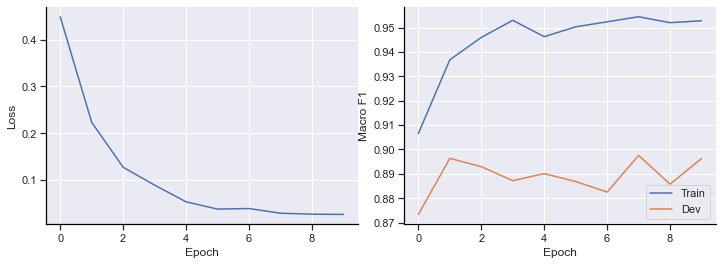

In [7]:
for limit in limit_list:
    print("Now testing size:", limit*2, "(limit is {})".format(limit))
    for batch_size, max_length in zip(batch_size_list, max_length_list):
        if not completed.get((limit*2, batch_size), False):
            print("Now testing batch size:", batch_size)
            # Train
            trainer.build_model(max_length, batch_size, learning_rate, epochs, num_labels=2, eval_batch_size=32)
            trainer.prepare_data(limit=limit)
            trainer.setup_training()
            trainer.train()

            # Get best dev score
            best_dev_score, best_dev_epoch, best_dev_total_time = trainer.history.get_best_dev()
            results.append([limit*2, batch_size, best_dev_score, best_dev_epoch, best_dev_total_time])
            pd.DataFrame(
                results, columns=["train_size", "batch_size", "best_dev_score", "epoch", "total_time"]
            ).to_excel("batch_size_experiment_results.xlsx", index=False)
        else:
            print("Already done")
        
        sub_pbar.update()
        
    main_pbar.update()
    sub_pbar.reset()